In [1]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import re
from scipy import interpolate
import manipulate_text as mt
import copy
import itertools
import argparse
import numpy.ma as ma
from scipy.optimize import minimize, fsolve
import time
from scipy.stats import norm
import matplotlib.mlab as mlab

In [2]:
#define relevant paths and names
#script_path = os.path.realpath(__file__) if a .py is run
script_path = os.getcwd()
base_path =  script_path.split('scripts')[0]
fits_path = base_path.split('Secondary_radiation')[0] + 'synchrotron_data/'
fits_name = 'm31cm3nthnew.ss.90sec.fits'
fig_path = base_path + 'figs/'

In [40]:
def get_data_and_info(fits_path, fits_name):
    #extract data and information about data
    hdul = fits.open(fits_path+fits_name)
    data_uJ = hdul[0].data[0]
    data = data_uJ/1000 #mJ/beam
    hdr = hdul[0].header
    dlt_N_deg = abs(hdr['CDELT1'])
    dlt_n_deg = abs(hdr['CDELT2'])
    N = hdr['NAXIS1']
    n = hdr['NAXIS2']
    nu_data = hdr['CRVAL3']
    nu_BW = hdr['CDELT3']
    HPBW_deg = hdr['BMIN']
    return data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW 

def make_coords(N, n, dlt_N, dlt_n, loc='centered'):
    if loc=='centered':
        ax_N_unit = np.linspace(-(N-1)/2, (N-1)/2, N)
        ax_n_unit = np.linspace(-(n-1)/2, (n-1)/2, n)
    elif loc=='edges':
        ax_N_unit = np.linspace(-N/2, N/2, N+1)
        ax_n_unit = np.linspace(-n/2, n/2, n+1)
    return dlt_N*ax_N_unit, dlt_n*ax_n_unit

def gen_fake_data(beam_cut, frac, sigma_rms, sigma_BW, N, n, dlt_N, dlt_n):
    num_beams = beam_cut+1
    
    #create coords for data
    ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
    AX_N, AX_n = np.meshgrid(ax_N, ax_n)
    
    #create coords for sources
    dlt_N_source = dlt_N/frac
    dlt_n_source = dlt_N_source
    fov_N = N*dlt_N
    print('fov N: ' + str(fov_N))
    fov_n = n*dlt_n
    print('fov n: ' + str(fov_n))
    fov_N_source = fov_N+2*num_beams*sigma_BW
    print('fov N source: ' + str(fov_N_source))
    fov_n_source = fov_n+2*num_beams*sigma_BW
    print('fov n source: ' + str(fov_n_source))
    N_source = int(np.round(fov_N_source/dlt_N_source))
    print('N source: ' + str(N_source))
    n_source = int(np.round(fov_n_source/dlt_n_source))
    print('n source: ' + str(n_source))
    fov_N_source = N_source*dlt_N_source
    fov_n_source = n_source*dlt_n_source
    ax_N_source, ax_n_source = make_coords(N_source, n_source, dlt_N_source, dlt_n_source)
    AX_N_SOURCE, AX_n_SOURCE = np.meshgrid(ax_N_source, ax_n_source)
    #smaller rms noise in the central lxb region where l and b are in degrees
    l = 2/3
    b = 2/3
    outside = np.logical_or(np.abs(AX_N_SOURCE)>(l/2)*np.pi/180, np.abs(AX_n_SOURCE)>(b/2)*np.pi/180)
    inside = np.logical_not(outside)
    noise = sigma_rms[-1]*outside + sigma_rms[0]*inside
    #generate fake data
    z = np.random.normal(size=(n_source, N_source))
    data_gen = 0*AX_N
    for i in range(n_source):
        for j in range(N_source):
            loc = (ax_n_source[i], ax_N_source[j])
            start_N = np.searchsorted(ax_N, loc[1]-beam_cut*sigma_BW, side='left')
            end_N = np.searchsorted(ax_N, loc[1]+beam_cut*sigma_BW, side='left')
            start_n = np.searchsorted(ax_n, loc[0]-beam_cut*sigma_BW, side='left')
            end_n = np.searchsorted(ax_n, loc[0]+beam_cut*sigma_BW, side='left')
            beam = dlt_N_source*noise[i,j]/(np.sqrt(np.pi)*sigma_BW)*z[i, j] \
                *np.exp(-((AX_N[start_n:end_n, start_N:end_N]-ax_N_source[j])**2+(AX_n[start_n:end_n, start_N:end_N]-ax_n_source[i])**2)/(2*sigma_BW**2))
            data_gen[start_n:end_n, start_N:end_N] += beam
    return data_gen, AX_N, AX_n

def gen_templates(run, nu, Omega_beam, AX_N, AX_n, test_conv=False):
    #get shape of map
    n, N = AX_N.shape
    
    #bring in variables from the run
    txt_file_name = run['file_name']
    nx = run['nx']
    nnu = run['nnu']
    ny = run['ny']
    thxrange=run['thx_range']
    thyrange=run['thy_range']
    sigmav_bench = run['sigma_v']
    nu_range = run['nu_range']
    astro_model = run['Astrophysical Model']
    am = __import__(astro_model)
    
    #process run variables
    array_file_name = txt_file_name.split('_info')[0] + '.npy'
    m = re.search('[0-9]{4}_', array_file_name)
    out_type = array_file_name.split('.npy')[0].split(m.group(0))[-1]
    
    #set coordinates for synchrotron spectrum
    nuv = np.logspace(np.log10(nu_range[0]), np.log10(nu_range[1]), nnu)
    thx_full = np.linspace(-thxrange, thxrange, 2*nx)
    thy_full = np.linspace(-thyrange, thyrange, 2*ny)
    thxv = thx_full[nx:]
    thyv = thy_full[ny:]
    thx2d, thy2d = np.meshgrid(thxv, thyv)
    thx3d = np.repeat(np.array([thx2d]), nnu, axis=0)
    thy3d = np.repeat(np.array([thy2d]), nnu, axis=0)
    nu3d = np.multiply.outer(nuv, np.ones((ny, nx)))
    
    #load synchrotron emission result
    dSdnudOmega = np.load(base_path + out_type + '/' + array_file_name) #erg cm^-2 s^-1 Sr^-1
    flux_beam = ((10**26/nu3d)*dSdnudOmega*Omega_beam).astype(np.float64)
    
    #determine central fequency
    ind_nu = np.where(np.min(np.abs(nuv-nu))==np.abs(nuv-nu))[0][0]
    if test_conv:
        #replace 0s with 1e-300
        nu_fin_ind = nnu
        #find max synch frequency index and extrapolate to rho=0
        for i in range(flux_init.shape[0]):
            zs = np.where(flux_init[i] == 0)
            if len(zs[0]) == nx*ny:
                nu_fin_ind = i #max frequency index + 1
                break
            else:
                for iy, ix in zip(zs[0], zs[1]):
                    flux_init[i, iy, ix] = 1e-300
        #copy results of analysis into other quadrants
        flux_init = flux_beam
        flux_flipx = np.flip(flux_init, axis=2)
        flux_new = np.concatenate((flux_flipx, flux_init), axis=2)
        flux_flipy = np.flip(flux_new, axis=1)
        flux = np.concatenate((flux_flipy, flux_new), axis=1)
        
        #Interpolate every frequency with respect to x and y
        lnflux_interp = [interpolate.interp2d(thx_full, thy_full, np.log(f), kind='cubic') for f in flux]
        
        #Convolve with gaussian beam for a few pixels and all frequencies
        #Interpolate with respect to nu for each spatial pixel that is computed at last step.
        #Convolve with gaussian in frequency for each of these pixels
        #Store x,y interpolation at the central frequency with a standard name
    else:
        #Do all of this for central frequency only
        flux_init = flux_beam[ind_nu]
        
        #copy results of analysis into other quadrants
        flux_flipx = np.flip(flux_init, axis=1)
        flux_new = np.concatenate((flux_flipx, flux_init), axis=1)
        flux_flipy = np.flip(flux_new, axis=0)
        flux = np.concatenate((flux_flipy, flux_new), axis=0)
        
        #Interpolate with respect to x and y
        lnflux_interp = interpolate.interp2d(thx_full, thy_full, np.log(flux), kind='cubic')
    return np.exp(lnflux_interp(AX_N[0], AX_n[:, 0]))

def sort_runs(mx_set, D0_set, args=None, rtrn='inds'):
    D0_vals = np.sort(np.unique(D0_set))
    ind_set = []
    for D0_val in D0_vals:
        ind_D0val = np.where(D0_set==D0_val)[0]
        p_D0val = np.argsort(mx_set[ind_D0val])
        ind_set.append(ind_D0val[p_D0val])
    ind_set_tup = tuple(ind_set)
    ind_full = np.hstack(ind_set_tup)
    if rtrn == 'inds':
        return ind_full
    elif rtrn == 'arrs':
        if args==None:
            return mx_set[ind_full], D0_set[ind_full]
        else:
            return mx_set[ind_full], D0_set[ind_full], tuple(args[i][ind_full] for i in range(len(args)))
        
#coords = (x, y)                                                                                                                                          
#ellipse_params = (r, a, thickness/2)  
def create_mask(THETA, th_range, ps_ind=None, rl=None, coords=None, ellipse_params=None, data=None,  sigma_rms=None, num_sigma_rms=None, sigma_BW=None, num_sigma_BW=None, dlt=None,\
 method='azimuthally_sym', num_sigma=1):
    m0 = 0*THETA==0
    m1 = m0
    m2 = m0
    m3 = m0
    if ps_ind is not None:
        m0[ps_ind]=False
    if method=='azimuthally_sym':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
    elif method=='ellipse_and_azimuthally_sym':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
        elliptic_d = np.sqrt(coords[0]**2+(ellipse_params[0]**2)*coords[1]**2)
        m2 = np.abs(elliptic_d-ellipse_params[1])>ellipse_params[2]
    elif method == 'ellipse_azimuthallysym_outside':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
        elliptic_d = np.sqrt(coords[0]**2+(ellipse_params[0]**2)*coords[1]**2)
        m2 = elliptic_d-ellipse_params[1]<-num_sigma*ellipse_params[2]
    elif method == 'ellipse_azimuthallysym_inside':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
        elliptic_d = np.sqrt(coords[0]**2+(ellipse_params[0]**2)*coords[1]**2)
        m2 = elliptic_d-ellipse_params[1]>-num_sigma*ellipse_params[2]
    if rl=='right':
        m3[np.where(AX_N>=0)] = False
    elif rl=='left':
        m3[np.where(AX_N<=0)] = False
    return m0*m1*m2*m3

def f_b0(x, w):
    return w*np.ones(x[0].shape)

def f_b1(x, w):
    elliptic_d = np.sqrt(x[0]**2+w[1]**2*x[1]**2)
    return w[0]*np.exp(-(elliptic_d-w[2])**2/(2*w[3]**2))

def f(x, w):
    return f_b0(x, w[0]) + f_b1(x, w[1:])

def chi2(w, *args):
    model = f(args[1], w)
    return np.sum(((args[0]-model)**2/args[2]**2)*args[3])

def find_best_fit(chi2_func, data, coords, mask, noise, w_init, bnds):

    print('initial values of the model params are: ', w_init)
    #plt.imshow(ma.array(f([AX_N, AX_n], w_init), mask=np.logical_not(this_mask)))

    #print initial statistics
    this_chi2 = chi2_func(w_init, *(data, coords,  noise, mask))
    statement1 = 'initial weights are: '
    for j in range(len(w_init)):
        statement1 += 'w' + str(j) + ' = ' + str(w_init[j]) + '; '
    print(statement1)
    print('chi^2 = ' + str(this_chi2))

    # update weights
    res = minimize(chi2_func, w_init, args=(data, coords, noise, mask), bounds=bnds)
    w_fin = res.x
    print('w_fin: ', w_fin)
    print(res.success)
    print(res.message)
    chi2_final = chi2_func(w_fin, *(data, coords, noise, mask))
    print('final chi2: '+ str(chi2_final)) 
    fig = plt.figure()
    new_model = f(coords, w_fin)
    model_ma = ma.array(new_model, mask=np.logical_not(mask))
    minmin = np.min(data)
    maxmax = np.max(data)
    plt.imshow(model_ma, extent=[coords[0][0, 0]*DA, coords[0][0, -1]*DA, coords[1][0, 0]*DA, coords[1][-1, 0]*DA], vmin=minmin, vmax=maxmax) 
    plt.xlabel(r'$x \; \rm{(kpc)}$', size=14)
    plt.ylabel(r'$y \; \rm{(kpc)}$', size=14)
    plt.title(r'Ellipse Plus Uniform Model Best Fit', size=14)
    cbar = plt.colorbar(orientation='horizontal')
    cbar.set_label(r'$\rm{mJy/beam}$', size=16)
    #plt.savefig(base_path+'figs/best_annulus_model.pdf')
    fig = plt.figure()
    plt.imshow(ma_data, vmin=minmin, vmax=maxmax)
    plt.colorbar(orientation='horizontal')
    return w_fin

def find_test_stats(resid, signal, background, sigma_rms, mask, this_ws, this_dw, this_chi_sb_sb, sigmav, sigmav_bench=2.2e-26):
    this_w0b = this_ws
    this_chi_b_b = this_chi_sb_sb
    this_w0s = this_ws+(sigmav/sigmav_bench)*this_dw
    this_wb = this_ws-(sigmav/sigmav_bench)*this_dw
    this_chi_b_sb = np.sum(mask*(resid+(sigmav/sigmav_bench)*signal-this_w0s*background)**2/(sigma_rms**2))
    this_chi_sb_b = np.sum(mask*(resid-(sigmav/sigmav_bench)*signal-this_wb*background)**2/(sigma_rms**2))
    this_delta_chi_b = this_chi_sb_b-this_chi_b_b
    this_delta_chi_sb = this_chi_sb_sb-this_chi_b_sb 
    return this_ws, this_w0b, this_w0s, this_wb, this_chi_sb_b, this_chi_b_sb, this_delta_chi_b, this_delta_chi_sb

def remove_ps(data, THETA, cent, ann1, ann2, thresh):
    #find center index
    ind0 = np.where(THETA==0)
    indy0 = ind0[0][0]
    indx0 = ind0[1][0]

    #find indices of annulus
    ind_ann0 = np.where(np.logical_and(THETA>ann1, THETA<ann2))
    dlt_ind_ann = (ind_ann0[0]-indy0, ind_ann0[1]-indx0)

    #find indices of center
    ind_cent0 = np.where(THETA<cent)
    dlt_ind_cent = (ind_cent0[0]-indy0, ind_cent0[1]-indx0)
    
    #prepare for for-loops
    sh = data.shape
    mask_indx = []
    mask_indy = []
    
    #iterate over each pixel, putting the circle and annulus centered over the pixel and computing the average
    #intensity in each. If the circle has an average intensity larger than the annulus by a certain amount
    #then store the indices of the circle for masking
    for i in range(sh[0]):
        #print('i: ', i)
        for j in range(sh[1]):
            ind_of_ind = [k for k in range(len(dlt_ind_ann[0])) \
                                  if j+dlt_ind_ann[1][k] < N and j+dlt_ind_ann[1][k] >= 0\
                                 and i+dlt_ind_ann[0][k] < n and i+dlt_ind_ann[0][k] >= 0]
            ind_ann_x = [int(j+dlt_ind_ann[1][ind]) for ind in ind_of_ind]
            ind_ann_y = [int(i+dlt_ind_ann[0][ind]) for ind in ind_of_ind]
            num_ann = len(ind_of_ind)

            ind_of_ind_cent = [k for k in range(len(dlt_ind_cent[0])) \
                                  if j+dlt_ind_cent[1][k] < N and j+dlt_ind_cent[1][k] >= 0\
                                 and i+dlt_ind_cent[0][k] < n and i+dlt_ind_cent[0][k] >= 0]
            ind_cent_x = [int(j+dlt_ind_cent[1][ind]) for ind in ind_of_ind_cent]
            ind_cent_y = [int(i+dlt_ind_cent[0][ind]) for ind in ind_of_ind_cent]
            num_cent = len(ind_of_ind_cent)

            #compute average intensity in annulus and center
            I_center = np.sum(data[(ind_cent_y, ind_cent_x)])/num_cent
            I_ann = np.sum(data[(ind_ann_y, ind_ann_x)])/num_ann

            if I_center > thresh[i,j]+I_ann: #or I_center < I_ann-thresh[i,j]: (include if voids should be masked)
                mask_indy += list(ind_cent_y)
                mask_indx += list(ind_cent_x)
                
    #remove repeated pairs of indices from the list of indices
    mask_inds_raw = np.array([mask_indy, mask_indx])
    print('raw indices found')
    mask_inds = np.unique(mask_inds_raw, axis=1)
    
    #plot data with masked indices indicated with scatter points
    #plt.imshow(data)
    #plt.scatter(mask_inds[1], mask_inds[0], s=2, color='r')
    
    return tuple(mask_inds)

def latex_float(f, n):
    kwrd = '{0:.' +str(n)+ 'g}'
    float_str = kwrd.format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [4]:
#extract info about data
data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW = get_data_and_info(fits_path, fits_name)
dlt_N = dlt_N_deg*np.pi/180
dlt_n = dlt_n_deg*np.pi/180
HPBW = HPBW_deg*np.pi/180
sigma_BW = HPBW/(2*np.sqrt(2*np.log(2)))
omega_beam = 2*np.pi*sigma_BW**2
print('real data info extracted')

real data info extracted


In [5]:
#create coords for data
ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
AX_N, AX_n = np.meshgrid(ax_N, ax_n)
THETA = np.sqrt(AX_N**2+AX_n**2)
sigma_rms = [0.25, 0.3]
l = 2/3
b = 2/3
outside = np.logical_or(np.abs(AX_N)>(l/2)*np.pi/180, np.abs(AX_n)>(b/2)*np.pi/180)
inside = np.logical_not(outside)
noise = sigma_rms[-1]*outside + sigma_rms[0]*inside
rl_mask = ''

In [6]:
#define dimensionless hyperparams
dless_rad0 = .75
dless_rad1 = 2.25
dless_rad2 = 2.5
num_sigmas = 4

#compute physical hyperparams
cent = dless_rad0*HPBW/2
ann1 = dless_rad1*HPBW/2
ann2 = dless_rad2*HPBW/2
thresh = num_sigmas*noise

mask_inds = remove_ps(data, THETA, cent, ann1, ann2, thresh)

raw indices found


In [189]:
len(mask_inds)

2

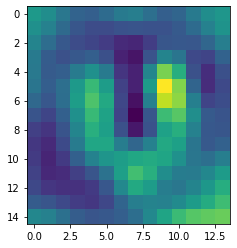

In [7]:
#mask extra pixels
ymin = 78
ymax = 92
xmin = 283
xmax = 296
plt.imshow(data[ymin:ymax+1, xmin:xmax+1])
rad = dlt_n*(ymax-ymin)/2
center = tuple((dlt_n*((ymin + (ymax - ymin)/2)-n/2), dlt_N*(xmin + (xmax - xmin)/2 - N/2)))
extra_inds = np.where((AX_N-center[1])**2+(AX_n-center[0])**2<rad**2)
mask_inds_extra = np.array([np.concatenate((mask_inds[i], extra_inds[i])) for i in range(2)])
mask_inds = tuple(np.unique(mask_inds_extra, axis=1))

0.0011865336088032082


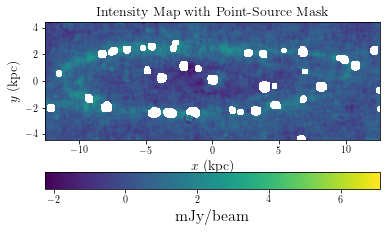

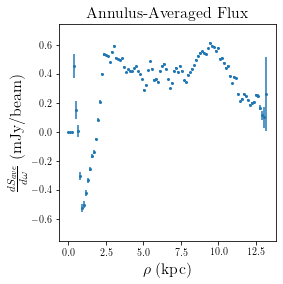

In [25]:
DA = 785
omega_pix = dlt_N*dlt_n
pix_per_beam = omega_beam/omega_pix
min_pix = pix_per_beam
this_mask = create_mask(THETA, [0, np.pi], ps_ind=mask_inds, coords=(AX_N, AX_n))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.imshow(ma.array(data, mask=np.logical_not(this_mask)), extent=[ax_N[0]*DA, ax_N[-1]*DA, ax_n[0]*DA, ax_n[-1]*DA], vmin=np.min(data), vmax = np.max(data))
plt.xlabel(r'$x \; \rm{(kpc)}$', size=14)
plt.ylabel(r'$y \; \rm{(kpc)}$', size=14)
plt.title(r'Intensity Map with Point-Source Mask', size=14)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$\rm{mJy/beam}$', size=16)
plt.savefig(base_path+'figs/intensity_map_w_ps_mask.pdf')
num_bins = 100
th_bins = np.linspace(0, np.max(THETA), num_bins+1)
flux_bin = np.zeros(num_bins)
pix_bin = np.zeros(num_bins)
er_flux = np.zeros(num_bins)
for i in range(num_bins):
    bool_bin = np.logical_and(THETA>=th_bins[i], THETA<th_bins[i+1])
    pix_bin[i] = np.sum(bool_bin*this_mask)
    flux_bin[i] = np.sum(data*bool_bin*this_mask)

er_ring = np.array([np.sqrt(pix_bin[i]/pix_per_beam)*(np.sum(noise*bool_bin*this_mask)/pix_bin[i]) if not pix_bin[i]==0 else 0 \
           for i in range(num_bins)])
mean_bin = np.array([flux_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
er_beam = np.array([er_ring[i]*(pix_per_beam/pix_bin[i]) if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
fig = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.scatter(th_bins[0:-1]*DA, mean_bin, s=4)
plt.errorbar(th_bins[0:-1]*DA, mean_bin, yerr=er_beam, fmt='none')
ax = plt.gca()
ax.set_ylim([-0.75, 0.75])
plt.xlabel(r'$\rho \; \rm{(kpc)}$', size=16)
plt.ylabel(r'$\frac{dS_{ave}}{d\omega}\; \rm{(mJy/beam)}$', size=16)
plt.title(r'Annulus-Averaged Flux', size=16)
ax.set_box_aspect(1)
#plt.savefig(base_path + 'figs/annulus_averaged_flux.pdf')
min_ind = np.where(np.min(mean_bin) == mean_bin)[0][0] 
th_mask = th_bins[min_ind]
print(th_mask)

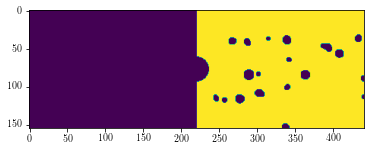

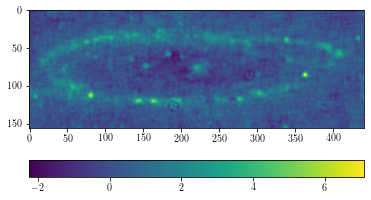

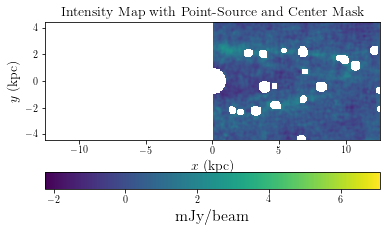

In [26]:
th_min = th_mask
#th_min = 0
th_max = np.pi
th_range_in = [th_min, th_max]
rl_mask='left'
base_mask = create_mask(THETA, th_range_in, ps_ind=mask_inds, rl=rl_mask)
plt.imshow(base_mask)
ma_data= ma.array(data, mask=np.logical_not(base_mask))
minmin = np.min(data)
maxmax = np.max(data)
fig = plt.figure()
plt.imshow(data, vmin=minmin, vmax=maxmax)
plt.colorbar(orientation='horizontal')
#plt.savefig(base_path+'figs/real_data.pdf')
fig = plt.figure()
plt.imshow(ma_data, extent=[ax_N[0]*DA, ax_N[-1]*DA, ax_n[0]*DA, ax_n[-1]*DA], vmin=minmin, vmax=maxmax)
plt.xlabel(r'$x \; \rm{(kpc)}$', size=14)
plt.ylabel(r'$y \; \rm{(kpc)}$', size=14)
plt.title(r'Intensity Map with Point-Source and Center Mask', size=14)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$\rm{mJy/beam}$', size=16)
#plt.savefig(base_path+'figs/ps_center_masked_data.pdf')

initial values of the model params are:  [0.0e+00 1.0e+00 4.0e+00 1.5e-02 3.0e-03]
initial weights are: w0 = 0.0; w1 = 1.0; w2 = 4.0; w3 = 0.015; w4 = 0.003; 
chi^2 = 103560.05213179924
w_fin:  [6.50505242e-03 8.86291775e-01 3.62919462e+00 1.18419179e-02
 3.04219817e-03]
True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
final chi2: 75030.78811565251


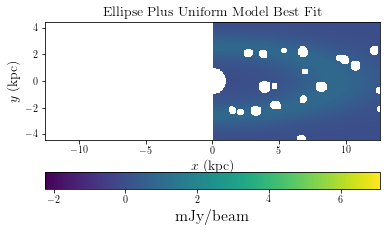

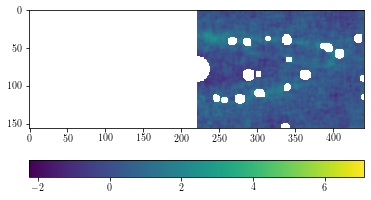

In [41]:
#zeroth order fit of ellipse
w_init = np.array([0,  1,  4,  0.015, 3e-3])
bnds = [(-1, 1), (0, 2), (3, 5), (.01 , 0.02), (1e-3, 1e-2)]
w_fin = find_best_fit(chi2, data, [AX_N, AX_n], base_mask, noise, w_init, bnds)

initial values of the model params are:  [6.50505242e-03 8.86291775e-01 3.62919462e+00 1.18419179e-02
 3.04219817e-03]
initial weights are: w0 = 0.0065050524224485136; w1 = 0.8862917752033403; w2 = 3.629194620422089; w3 = 0.011841917873789354; w4 = 0.0030421981715728647; 
chi^2 = 67273.70408770938
w_fin:  [1.18900910e-01 7.91274412e-01 3.65176688e+00 1.16722461e-02
 2.70907608e-03]
True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
final chi2: 66275.22114558809


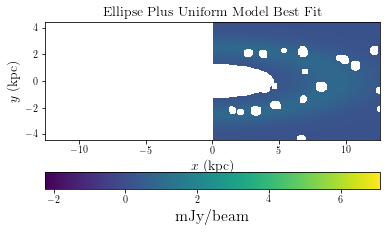

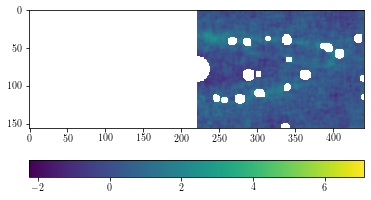

In [28]:
#first order fit of ellipse
#find ellipse shape while masking everything more than 2\sigma from the peak of the zeroth order ellipse on the inside

w_init = np.array(w_fin)
print('initial values of the model params are: ', w_init)
#plt.imshow(ma.array(f([AX_N, AX_n], w_init), mask=np.logical_not(this_mask)))
ell_params = list(w_fin[1:]).copy()
inside_mask = create_mask(THETA, th_range_in, ps_ind=mask_inds, coords=(AX_N, AX_n), ellipse_params=[ell_params[1], ell_params[2], ell_params[3]], \
                        num_sigma=2, method='ellipse_azimuthallysym_inside', rl=rl_mask)
#print initial statistics
this_chi2 = chi2(w_init, *(data, [AX_N, AX_n],  noise, inside_mask))
statement1 = 'initial weights are: '
for j in range(len(w_init)):
    statement1 += 'w' + str(j) + ' = ' + str(w_init[j]) + '; '
print(statement1)
print('chi^2 = ' + str(this_chi2))

# update weights
bnds = [(-1, 2), (0, 2), (3, 5), (.001 , 0.02), (1e-3, 1e-2)]
res = minimize(chi2, w_init, args=(data, [AX_N, AX_n], noise, inside_mask), bounds=bnds)

w_fin2 = res.x
print('w_fin: ', w_fin2)
print(res.success)
print(res.message)
chi2_final = chi2(w_fin2, *(data, [AX_N, AX_n], noise, inside_mask))
print('final chi2: '+ str(chi2_final)) 
fig = plt.figure()
new_model = f([AX_N, AX_n], w_fin2)
model_ma = ma.array(new_model, mask=np.logical_not(inside_mask))
plt.imshow(model_ma, extent=[ax_N[0]*DA, ax_N[-1]*DA, ax_n[0]*DA, ax_n[-1]*DA], vmin=minmin, vmax=maxmax) 
plt.xlabel(r'$x \; \rm{(kpc)}$', size=14)
plt.ylabel(r'$y \; \rm{(kpc)}$', size=14)
plt.title(r'Ellipse Plus Uniform Model Best Fit', size=14)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$\rm{mJy/beam}$', size=16)
#plt.savefig(base_path+'figs/best_annulus_model.pdf')
fig = plt.figure()
plt.imshow(ma_data, vmin=minmin, vmax=maxmax)
plt.colorbar(orientation='horizontal')


standard deviation of residuals =  0.39927294367600785
mean of residuals =  -0.4787209421567146


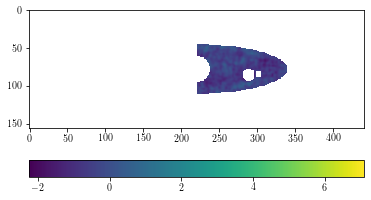

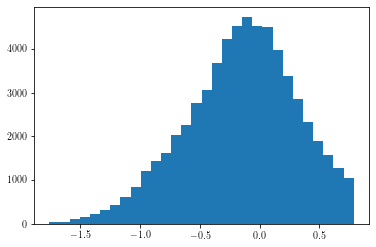

In [228]:
resid_real = data - new_model
plt.imshow(ma.array(resid_real, mask=np.logical_not(mask_set[0])), vmin = minmin, vmax = maxmax)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.hist(ma.array(resid_real, mask=np.logical_not(mask_set[0])).reshape(N*n), bins=30)
print('standard deviation of residuals = ', np.std(ma.array(resid_real, mask=np.logical_not(mask_set[0])).reshape(N*n)))
print('mean of residuals = ', np.mean(ma.array(resid_real, mask=np.logical_not(mask_set[0])).reshape(N*n)))

In [29]:
mode = 'load'
starting_sample = 0
num_samples = 4000
ell_params2 = list(w_fin2[1:])
print(ell_params2)

[0.7912744123306513, 3.651766883518428, 0.011672246074722985, 0.0027090760814744573]


In [30]:
#prepare sets of sigmav mx and D0
frac = 2.7
beam_cut = 5
sig_type = 2
sigmav_bench = 2.2e-26
mx_start = 6
mx_stop = 500
num_mx = 20
sigmav_start = -27
sigmav_end = -23
num_sigmav = 80
mask_thick_dless = np.array([1])
num_masks = len(mask_thick_dless)

#make these be  in increasing order
#D0_set_in = np.array([5e27, 1.1e28, 5e28, 2e29])
D0_set_in = np.array([3e27, 3e28, 3e29])
mx_set_in = np.round(np.logspace(np.log10(mx_start), np.log10(mx_stop), num_mx), 1)
sigmav_ar = np.logspace(sigmav_start, sigmav_end, num_sigmav)

[0.0011865336088032082, 3.141592653589793]


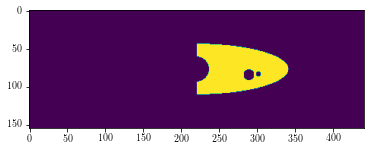

In [31]:
#create masks
rl_mask = 'left'
mask_set=[]
for thickness in mask_thick_dless:
    this_mask = create_mask(THETA, th_range_in, ps_ind=mask_inds, coords=(AX_N, AX_n), ellipse_params=[ell_params[1], ell_params[2], ell_params[3]], \
                        method='ellipse_azimuthallysym_outside', rl=rl_mask)
    mask_set.append(this_mask)
mask_set = np.array(mask_set)
print(th_range_in)
plt.imshow(mask_set[0])

initial values of the model params are:  [6.50505242e-03 8.86291775e-01 3.62919462e+00 1.18419179e-02
 3.04219817e-03]
initial weights are: w0 = 0.11890090952097225; w1 = 0.7912744123306513; w2 = 3.651766883518428; 
chi^2 = 18133.965654789296
w_fin:  [-0.33591251  1.4944039   0.00309891]
True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
final chi2: 11975.35746951932


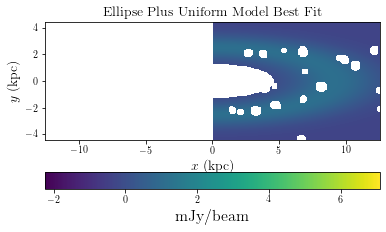

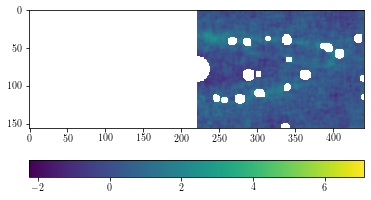

In [33]:
#fit width and magnitude 
w_inside = [w_fin2[0], w_fin2[1], w_fin2[4]]
print('initial values of the model params are: ', w_init)
#plt.imshow(ma.array(f([AX_N, AX_n], w_init), mask=np.logical_not(this_mask)))
outside_mask = mask_set[0]

def chi2_inside(w, *args):
    w_old = args[0]
    data = args[1]
    x = args[2]
    noise = args[3]
    mask = args[4]
    w_full = [w[0], w[1], w_old[0], w_old[1], w[2]]
    res = np.sum(mask*(data - f(x, w_full))**2/noise**2)
    return res

this_chi2 = chi2_inside(w_inside, *(w_fin2[2:4], data, [AX_N, AX_n],  noise, outside_mask))
statement1 = 'initial weights are: '
for j in range(len(w_inside)):
    statement1 += 'w' + str(j) + ' = ' + str(w_fin2[j]) + '; '
print(statement1)
print('chi^2 = ' + str(this_chi2))

# update weights
bnds = [(-1, 2), (0, 2), (1e-3, 1e-2)]
res = minimize(chi2_inside, w_inside, args=(w_fin2[2:4], data, [AX_N, AX_n], noise, outside_mask), bounds=bnds)

winside_fin = res.x
print('w_fin: ', winside_fin)
print(res.success)
print(res.message)
chi2_final = chi2_inside(winside_fin, *(w_fin2[2:4], data, [AX_N, AX_n], noise, outside_mask))
print('final chi2: '+ str(chi2_final)) 
fig = plt.figure()
w_modified = [winside_fin[0], winside_fin[1], w_fin2[2], w_fin2[3], winside_fin[2]]
new_model = f([AX_N, AX_n], w_modified)
model_ma = ma.array(new_model, mask=np.logical_not(inside_mask))
plt.imshow(model_ma, extent=[ax_N[0]*DA, ax_N[-1]*DA, ax_n[0]*DA, ax_n[-1]*DA], vmin=minmin, vmax=maxmax) 
plt.xlabel(r'$x \; \rm{(kpc)}$', size=14)
plt.ylabel(r'$y \; \rm{(kpc)}$', size=14)
plt.title(r'Ellipse Plus Uniform Model Best Fit', size=14)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$\rm{mJy/beam}$', size=16)
#plt.savefig(base_path+'figs/best_annulus_model.pdf')
fig = plt.figure()
plt.imshow(ma_data, vmin=minmin, vmax=maxmax)
plt.colorbar(orientation='horizontal')


In [287]:
#extract info of runs that match criteria
run_list = mt.find_results(sig_type, astro_model='Andromeda1', spherical_ave='weighted_dl', D0=D0_set_in, mx=mx_set_in)
run_list = run_list[0:int(len(run_list)/2)]
num_runs = len(run_list)
print('length of run_list: ', str(num_runs))

signal_temp_set = []
mx_set_out = []
D0_set_out = []
for run in run_list:
    print(run)
    mx_set_out.append(run['mx'])
    D0_set_out.append(run['D0'])
    this_signal_temp = gen_templates(run, nu_data, omega_beam, AX_N, AX_n)
    signal_temp_set.append(this_signal_temp)
mx_set_out = np.array(mx_set_out)
D0_set_out = np.array(D0_set_out)
signal_temp_set = np.array(signal_temp_set)

#sort runs
ind = sort_runs(mx_set_out, D0_set_out)
mx_set_out = mx_set_out[ind]
D0_set_out = D0_set_out[ind]
signal_temp_set = signal_temp_set[ind]
run_list = [run_list[i] for i in ind]

0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
0.017
length of run_list:  60
{'file_name': '0121_synchrotron_emission_info.txt', 'mx': 6.0, 'D0': 3e+27, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DM_model': 'model type- NFW; rho0- 0.43GeV/cm^3; gamma- 1.25; Scale Radius- 16.5kpc; ', 'Astrophysical Model': 'Andr

{'file_name': '0146_synchrotron_emission_info.txt', 'mx': 38.6, 'D0': 3e+28, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DM_model': 'model type- NFW; rho0- 0.43GeV/cm^3; gamma- 1.25; Scale Radius- 16.5kpc; ', 'Astrophysical Model': 'Andromeda1', 'Spherical Average': 'weighted_dl', 'nx': 58, 'ny': 20, 'nnu': 3, 'thx_range': 0.017, 'thy_range': 0.006, 'nu_range': [5050000000.0, 11650000000.0], 'nu_spacing': 'lin'}
{'file_name': '0147_synchrotron_emission_info.txt', 'mx': 38.6, 'D0': 3e+29, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DM_model': 'model type- NFW; rho0- 0.43GeV/cm^3; gamma- 1.25; Scale Radius- 16.5kpc; ', 'Astrophysical Model': 'Andromeda1', 'Spherical Average': 'weighted_dl', 'nx': 58, 'ny': 20, 'nnu': 3, 'thx_range': 0.017, 'thy_range': 0.006, 'nu_range': [5050000000.0, 11650000000.0], 'nu_spacing': 'lin'}
{'file_name': '0148_synchrotron_emission_info.txt', 'mx': 48.8, 'D0': 3e+27, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v

{'file_name': '0175_synchrotron_emission_info.txt', 'mx': 396.2, 'D0': 3e+27, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DM_model': 'model type- NFW; rho0- 0.43GeV/cm^3; gamma- 1.25; Scale Radius- 16.5kpc; ', 'Astrophysical Model': 'Andromeda1', 'Spherical Average': 'weighted_dl', 'nx': 58, 'ny': 20, 'nnu': 3, 'thx_range': 0.017, 'thy_range': 0.006, 'nu_range': [5050000000.0, 11650000000.0], 'nu_spacing': 'lin'}
{'file_name': '0176_synchrotron_emission_info.txt', 'mx': 396.2, 'D0': 3e+28, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DM_model': 'model type- NFW; rho0- 0.43GeV/cm^3; gamma- 1.25; Scale Radius- 16.5kpc; ', 'Astrophysical Model': 'Andromeda1', 'Spherical Average': 'weighted_dl', 'nx': 58, 'ny': 20, 'nnu': 3, 'thx_range': 0.017, 'thy_range': 0.006, 'nu_range': [5050000000.0, 11650000000.0], 'nu_spacing': 'lin'}
{'file_name': '0177_synchrotron_emission_info.txt', 'mx': 396.2, 'D0': 3e+29, 'channel': 'bb_bar', 'nr': 800, 'nE': 400, 'sigm

In [288]:
#initialize arrays
dchi2_sb = np.zeros((num_masks, num_runs, num_sigmav, num_samples+1))
dchi2_b = np.zeros((num_masks, num_runs, num_sigmav, num_samples+1))

In [289]:
#compute quantities that do not need to be recalculated for each image
#isotropic background template
b0 = np.ones((n,N))
unit_wfin2 = np.copy(w_fin2)
unit_wfin2[0] = 0
unit_wfin2[1] = 1
b1 = f([AX_N, AX_n], unit_wfin2)

P0 = (np.repeat(np.array([b0]), num_masks, axis=0) - np.multiply.outer((np.sum(mask_set*b0*b1/noise**2, axis=(1,2))/np.sum(mask_set*b1*b1/noise**2, axis=(1,2))), b1))\
/np.repeat(np.array([np.sum(mask_set*b0*b0/noise**2, axis=(1,2)) - np.sum(mask_set*b0*b1/noise**2, axis=(1,2))/np.sum(mask_set*b1*b1/noise**2, axis=(1,2))]), num_masks, axis=0)

P1 = (np.repeat(np.array([b1]), num_masks, axis=0) - np.multiply.outer((np.sum(mask_set*b1*b0/noise**2, axis=(1,2))/np.sum(mask_set*b0*b0/noise**2, axis=(1,2))), b0))\
/np.repeat(np.array([np.sum(mask_set*b1*b1/noise**2, axis=(1,2)) - np.sum(mask_set*b1*b0/noise**2, axis=(1,2))/np.sum(mask_set*b0*b0/noise**2, axis=(1,2))]), num_masks, axis=0)

# #sums in dchi^2 that are independent of simulated intensity map
sum3 = np.einsum('ijk,ljk', mask_set, signal_temp_set**2/noise**2)
sum4_0 = np.sum(mask_set*b0*b0/(noise**2), axis=(1,2))
sum4_01 = np.sum(mask_set*b0*b1/(noise**2), axis=(1,2))
sum4_1 = np.sum(mask_set*b1*b1/(noise**2), axis=(1,2))
sum5_0 = 2*np.einsum('ijk,ljk', mask_set, signal_temp_set*b0/noise**2)
sum5_1 = 2*np.einsum('ijk,ljk', mask_set, signal_temp_set*b1/noise**2)

# #how much should the background models change by if we add or subtract the signals
dw0 = np.einsum('ljk,ijk', mask_set*P0, signal_temp_set/noise**2).T
dw1 = np.einsum('ljk,ijk', mask_set*P1, signal_temp_set/noise**2).T
dw0_sigmav = np.multiply.outer(dw0, sigmav_ar/sigmav_bench)
dw1_sigmav = np.multiply.outer(dw1, sigmav_ar/sigmav_bench)

#coefficients in dchi^2 that are independent of simulated intensity map. Signs on coefficeints
#are correct for dchi^2_b and some signs my need to change for dchi^2_sb
coef1_0 = 2*dw0_sigmav #sum1
coef1_1 = 2*dw1_sigmav #sum1
coef2 = -2*sigmav_ar/sigmav_bench #sum2
coef3 = (sigmav_ar/sigmav_bench)**2 #sum3; opposite sign for sb
#check signs
coef5_0 = dw0_sigmav**2 #sum4_0; opposite sign for sb
coef5_1 = dw1_sigmav**2 #sum4_1; opposite sign for sb
coef5_01 = 2*dw0_sigmav*dw1_sigmav #sum4_01; opposite sign for sb
coef7_0 = - dw0_sigmav*sigmav_ar/sigmav_bench #sum5_0; opposite sign for sb
coef7_1 = - dw1_sigmav*sigmav_ar/sigmav_bench #sum5_1; opposite sign for sb
#terms in dchi^2 that are independent of simulated intensity map. Signs are correct for 
#dchi^2_b and signs need to be flipped  for dchi^2_sb where indicated
term3 = np.multiply.outer(sum3, coef3) #opposite sign for sb
term5_0 = (coef5_0.transpose((1, 2, 0))*sum4_0).transpose((2,0,1)) #opposite sign for sb
term5_1 = (coef5_1.transpose((1, 2, 0))*sum4_1).transpose((2,0,1)) #opposite sign for sb
term5_01 = (coef5_01.transpose((1, 2, 0))*sum4_01).transpose((2,0,1)) #opposite sign for sb
term7_0 = (coef7_0.transpose((2, 0, 1))*sum5_0).transpose((1, 2, 0)) #opposite_sign for sb
term7_1 = (coef7_1.transpose((2, 0, 1))*sum5_1).transpose((1, 2, 0)) #opposite_sign for sb

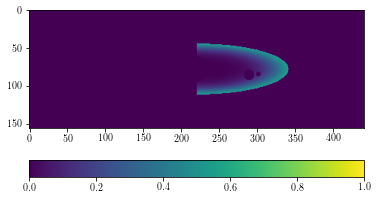

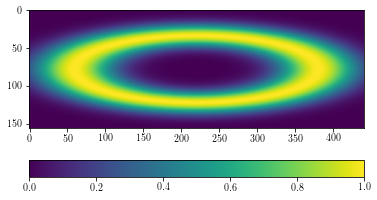

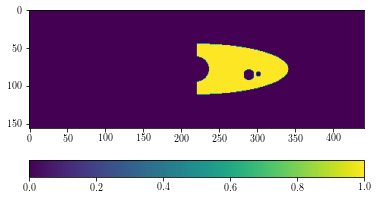

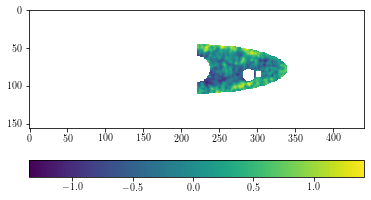

In [290]:
plt.figure()
plt.imshow(mask_set[0]*b1, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(b1, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(mask_set[0])
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(ma.array(data, mask=np.logical_not(mask_set[0])))
plt.colorbar(orientation='horizontal')

In [291]:
for i in range(num_samples+1):
    if i<num_samples:
        print('starting to generate sample number ' + str(i))
        #generate fake data residuals                                                                                                                                                       
        file_name_base = base_path + 'fake_resid_new/sigma_rms_'+ str(sigma_rms[0]) + '_' + \
                         str(sigma_rms[-1]) + '_spacing_' + '{:.2e}'.format(dlt_N/frac) + '_samplenum_'
        file_name=file_name_base+str(i+starting_sample) + '.npy'
        if mode == 'save' or mode == 'none':
            data_resid, _, _ = gen_fake_data(beam_cut, frac, sigma_rms_vals, sigma_BW, N, n, dlt_N, dlt_n)
            if mode == 'save':
                np.save(file_name, data_resid)
            print('sample number '+ str(starting_samples[0]+i) + ' generated')
        elif mode == 'load':
            data_resid = np.load(file_name)
        else:
            print('value mode is not recognized')
        #add residuals to best fit ring model                                                                                                                                               
        w_sim = [0] + ell_params2
        fake_bmap = data_resid  + f([AX_N, AX_n], w_sim) 
    else:
        #on the last iteration, use real data
        fake_bmap = data

    this_w0sb_sb = np.sum(mask_set*P0*fake_bmap/noise**2, axis=(1,2))
    this_w1sb_sb = np.sum(mask_set*P1*fake_bmap/noise**2, axis=(1,2))

    sum1_0 = np.sum(mask_set*fake_bmap*b0/noise**2, axis=(1,2))
    sum1_1 = np.sum(mask_set*fake_bmap*b1/noise**2, axis=(1,2))
    
    sum2 = np.einsum('ijk,ljk', mask_set*fake_bmap/(noise**2) , signal_temp_set)

    coef4_0 = -2*(dw0_sigmav.transpose((1, 2, 0))*this_w0sb_sb).transpose((2,0,1))#sum4
    coef4_1 = -2*(dw1_sigmav.transpose((1, 2, 0))*this_w1sb_sb).transpose((2,0,1))#sum4
    coef4_01 = -2*(dw0_sigmav.transpose((1, 2, 0))*this_w1sb_sb).transpose((2,0,1))#sum4
    coef4_10 = -2*(dw1_sigmav.transpose((1, 2, 0))*this_w0sb_sb).transpose((2,0,1))#sum4
    #(wait to assemble coef6 until combining it with sum5)

    term1_0 = (coef1_0.transpose((1,2,0))*sum1_0).transpose((2,0,1))
    term1_1 = (coef1_1.transpose((1,2,0))*sum1_1).transpose((2,0,1))
    term2 = np.multiply.outer(sum2, coef2)
    term4_0 = (coef4_0.transpose((1, 2, 0))*sum4_0).transpose((2,0,1))
    term4_1 = (coef4_1.transpose((1, 2, 0))*sum4_1).transpose((2,0,1))
    term4_01 = ((coef4_10 + coef4_01).transpose((1, 2, 0))*sum4_01).transpose((2,0,1))
    term6_0 = np.multiply.outer(((sum5_0.T*this_w0sb_sb).T), sigmav_ar/sigmav_bench)
    term6_1 = np.multiply.outer(((sum5_1.T*this_w1sb_sb).T), sigmav_ar/sigmav_bench)

    this_dchi2_b = term1_0 + term1_1 + term2 + term3 + term4_0 + term4_1 + term4_01 + term5_0 + term5_1 + term5_01 \
    + term6_0 + term6_1 + term7_0 + term7_1
    
    this_dchi2_sb = term1_0 + term1_1 + term2 - term3 + term4_0 + term4_1 + term4_01 - term5_0 - term5_1 - term5_01 \
    + term6_0 + term6_1 - term7_0 - term7_1
    
    dchi2_b[:, : , :, i] = this_dchi2_b
    dchi2_sb[:, : , :, i] = this_dchi2_sb


starting to generate sample number 0
starting to generate sample number 1
starting to generate sample number 2
starting to generate sample number 3
starting to generate sample number 4
starting to generate sample number 5
starting to generate sample number 6
starting to generate sample number 7
starting to generate sample number 8
starting to generate sample number 9
starting to generate sample number 10
starting to generate sample number 11
starting to generate sample number 12
starting to generate sample number 13
starting to generate sample number 14
starting to generate sample number 15
starting to generate sample number 16
starting to generate sample number 17
starting to generate sample number 18
starting to generate sample number 19
starting to generate sample number 20
starting to generate sample number 21
starting to generate sample number 22
starting to generate sample number 23
starting to generate sample number 24
starting to generate sample number 25
starting to generate s

starting to generate sample number 222
starting to generate sample number 223
starting to generate sample number 224
starting to generate sample number 225
starting to generate sample number 226
starting to generate sample number 227
starting to generate sample number 228
starting to generate sample number 229
starting to generate sample number 230
starting to generate sample number 231
starting to generate sample number 232
starting to generate sample number 233
starting to generate sample number 234
starting to generate sample number 235
starting to generate sample number 236
starting to generate sample number 237
starting to generate sample number 238
starting to generate sample number 239
starting to generate sample number 240
starting to generate sample number 241
starting to generate sample number 242
starting to generate sample number 243
starting to generate sample number 244
starting to generate sample number 245
starting to generate sample number 246
starting to generate samp

starting to generate sample number 437
starting to generate sample number 438
starting to generate sample number 439
starting to generate sample number 440
starting to generate sample number 441
starting to generate sample number 442
starting to generate sample number 443
starting to generate sample number 444
starting to generate sample number 445
starting to generate sample number 446
starting to generate sample number 447
starting to generate sample number 448
starting to generate sample number 449
starting to generate sample number 450
starting to generate sample number 451
starting to generate sample number 452
starting to generate sample number 453
starting to generate sample number 454
starting to generate sample number 455
starting to generate sample number 456
starting to generate sample number 457
starting to generate sample number 458
starting to generate sample number 459
starting to generate sample number 460
starting to generate sample number 461
starting to generate samp

starting to generate sample number 660
starting to generate sample number 661
starting to generate sample number 662
starting to generate sample number 663
starting to generate sample number 664
starting to generate sample number 665
starting to generate sample number 666
starting to generate sample number 667
starting to generate sample number 668
starting to generate sample number 669
starting to generate sample number 670
starting to generate sample number 671
starting to generate sample number 672
starting to generate sample number 673
starting to generate sample number 674
starting to generate sample number 675
starting to generate sample number 676
starting to generate sample number 677
starting to generate sample number 678
starting to generate sample number 679
starting to generate sample number 680
starting to generate sample number 681
starting to generate sample number 682
starting to generate sample number 683
starting to generate sample number 684
starting to generate samp

starting to generate sample number 886
starting to generate sample number 887
starting to generate sample number 888
starting to generate sample number 889
starting to generate sample number 890
starting to generate sample number 891
starting to generate sample number 892
starting to generate sample number 893
starting to generate sample number 894
starting to generate sample number 895
starting to generate sample number 896
starting to generate sample number 897
starting to generate sample number 898
starting to generate sample number 899
starting to generate sample number 900
starting to generate sample number 901
starting to generate sample number 902
starting to generate sample number 903
starting to generate sample number 904
starting to generate sample number 905
starting to generate sample number 906
starting to generate sample number 907
starting to generate sample number 908
starting to generate sample number 909
starting to generate sample number 910
starting to generate samp

starting to generate sample number 1107
starting to generate sample number 1108
starting to generate sample number 1109
starting to generate sample number 1110
starting to generate sample number 1111
starting to generate sample number 1112
starting to generate sample number 1113
starting to generate sample number 1114
starting to generate sample number 1115
starting to generate sample number 1116
starting to generate sample number 1117
starting to generate sample number 1118
starting to generate sample number 1119
starting to generate sample number 1120
starting to generate sample number 1121
starting to generate sample number 1122
starting to generate sample number 1123
starting to generate sample number 1124
starting to generate sample number 1125
starting to generate sample number 1126
starting to generate sample number 1127
starting to generate sample number 1128
starting to generate sample number 1129
starting to generate sample number 1130
starting to generate sample number 1131


starting to generate sample number 1323
starting to generate sample number 1324
starting to generate sample number 1325
starting to generate sample number 1326
starting to generate sample number 1327
starting to generate sample number 1328
starting to generate sample number 1329
starting to generate sample number 1330
starting to generate sample number 1331
starting to generate sample number 1332
starting to generate sample number 1333
starting to generate sample number 1334
starting to generate sample number 1335
starting to generate sample number 1336
starting to generate sample number 1337
starting to generate sample number 1338
starting to generate sample number 1339
starting to generate sample number 1340
starting to generate sample number 1341
starting to generate sample number 1342
starting to generate sample number 1343
starting to generate sample number 1344
starting to generate sample number 1345
starting to generate sample number 1346
starting to generate sample number 1347


starting to generate sample number 1535
starting to generate sample number 1536
starting to generate sample number 1537
starting to generate sample number 1538
starting to generate sample number 1539
starting to generate sample number 1540
starting to generate sample number 1541
starting to generate sample number 1542
starting to generate sample number 1543
starting to generate sample number 1544
starting to generate sample number 1545
starting to generate sample number 1546
starting to generate sample number 1547
starting to generate sample number 1548
starting to generate sample number 1549
starting to generate sample number 1550
starting to generate sample number 1551
starting to generate sample number 1552
starting to generate sample number 1553
starting to generate sample number 1554
starting to generate sample number 1555
starting to generate sample number 1556
starting to generate sample number 1557
starting to generate sample number 1558
starting to generate sample number 1559


starting to generate sample number 1744
starting to generate sample number 1745
starting to generate sample number 1746
starting to generate sample number 1747
starting to generate sample number 1748
starting to generate sample number 1749
starting to generate sample number 1750
starting to generate sample number 1751
starting to generate sample number 1752
starting to generate sample number 1753
starting to generate sample number 1754
starting to generate sample number 1755
starting to generate sample number 1756
starting to generate sample number 1757
starting to generate sample number 1758
starting to generate sample number 1759
starting to generate sample number 1760
starting to generate sample number 1761
starting to generate sample number 1762
starting to generate sample number 1763
starting to generate sample number 1764
starting to generate sample number 1765
starting to generate sample number 1766
starting to generate sample number 1767
starting to generate sample number 1768


starting to generate sample number 1949
starting to generate sample number 1950
starting to generate sample number 1951
starting to generate sample number 1952
starting to generate sample number 1953
starting to generate sample number 1954
starting to generate sample number 1955
starting to generate sample number 1956
starting to generate sample number 1957
starting to generate sample number 1958
starting to generate sample number 1959
starting to generate sample number 1960
starting to generate sample number 1961
starting to generate sample number 1962
starting to generate sample number 1963
starting to generate sample number 1964
starting to generate sample number 1965
starting to generate sample number 1966
starting to generate sample number 1967
starting to generate sample number 1968
starting to generate sample number 1969
starting to generate sample number 1970
starting to generate sample number 1971
starting to generate sample number 1972
starting to generate sample number 1973


starting to generate sample number 2168
starting to generate sample number 2169
starting to generate sample number 2170
starting to generate sample number 2171
starting to generate sample number 2172
starting to generate sample number 2173
starting to generate sample number 2174
starting to generate sample number 2175
starting to generate sample number 2176
starting to generate sample number 2177
starting to generate sample number 2178
starting to generate sample number 2179
starting to generate sample number 2180
starting to generate sample number 2181
starting to generate sample number 2182
starting to generate sample number 2183
starting to generate sample number 2184
starting to generate sample number 2185
starting to generate sample number 2186
starting to generate sample number 2187
starting to generate sample number 2188
starting to generate sample number 2189
starting to generate sample number 2190
starting to generate sample number 2191
starting to generate sample number 2192


starting to generate sample number 2380
starting to generate sample number 2381
starting to generate sample number 2382
starting to generate sample number 2383
starting to generate sample number 2384
starting to generate sample number 2385
starting to generate sample number 2386
starting to generate sample number 2387
starting to generate sample number 2388
starting to generate sample number 2389
starting to generate sample number 2390
starting to generate sample number 2391
starting to generate sample number 2392
starting to generate sample number 2393
starting to generate sample number 2394
starting to generate sample number 2395
starting to generate sample number 2396
starting to generate sample number 2397
starting to generate sample number 2398
starting to generate sample number 2399
starting to generate sample number 2400
starting to generate sample number 2401
starting to generate sample number 2402
starting to generate sample number 2403
starting to generate sample number 2404


starting to generate sample number 2589
starting to generate sample number 2590
starting to generate sample number 2591
starting to generate sample number 2592
starting to generate sample number 2593
starting to generate sample number 2594
starting to generate sample number 2595
starting to generate sample number 2596
starting to generate sample number 2597
starting to generate sample number 2598
starting to generate sample number 2599
starting to generate sample number 2600
starting to generate sample number 2601
starting to generate sample number 2602
starting to generate sample number 2603
starting to generate sample number 2604
starting to generate sample number 2605
starting to generate sample number 2606
starting to generate sample number 2607
starting to generate sample number 2608
starting to generate sample number 2609
starting to generate sample number 2610
starting to generate sample number 2611
starting to generate sample number 2612
starting to generate sample number 2613


starting to generate sample number 2804
starting to generate sample number 2805
starting to generate sample number 2806
starting to generate sample number 2807
starting to generate sample number 2808
starting to generate sample number 2809
starting to generate sample number 2810
starting to generate sample number 2811
starting to generate sample number 2812
starting to generate sample number 2813
starting to generate sample number 2814
starting to generate sample number 2815
starting to generate sample number 2816
starting to generate sample number 2817
starting to generate sample number 2818
starting to generate sample number 2819
starting to generate sample number 2820
starting to generate sample number 2821
starting to generate sample number 2822
starting to generate sample number 2823
starting to generate sample number 2824
starting to generate sample number 2825
starting to generate sample number 2826
starting to generate sample number 2827
starting to generate sample number 2828


starting to generate sample number 3016
starting to generate sample number 3017
starting to generate sample number 3018
starting to generate sample number 3019
starting to generate sample number 3020
starting to generate sample number 3021
starting to generate sample number 3022
starting to generate sample number 3023
starting to generate sample number 3024
starting to generate sample number 3025
starting to generate sample number 3026
starting to generate sample number 3027
starting to generate sample number 3028
starting to generate sample number 3029
starting to generate sample number 3030
starting to generate sample number 3031
starting to generate sample number 3032
starting to generate sample number 3033
starting to generate sample number 3034
starting to generate sample number 3035
starting to generate sample number 3036
starting to generate sample number 3037
starting to generate sample number 3038
starting to generate sample number 3039
starting to generate sample number 3040


starting to generate sample number 3231
starting to generate sample number 3232
starting to generate sample number 3233
starting to generate sample number 3234
starting to generate sample number 3235
starting to generate sample number 3236
starting to generate sample number 3237
starting to generate sample number 3238
starting to generate sample number 3239
starting to generate sample number 3240
starting to generate sample number 3241
starting to generate sample number 3242
starting to generate sample number 3243
starting to generate sample number 3244
starting to generate sample number 3245
starting to generate sample number 3246
starting to generate sample number 3247
starting to generate sample number 3248
starting to generate sample number 3249
starting to generate sample number 3250
starting to generate sample number 3251
starting to generate sample number 3252
starting to generate sample number 3253
starting to generate sample number 3254
starting to generate sample number 3255


starting to generate sample number 3450
starting to generate sample number 3451
starting to generate sample number 3452
starting to generate sample number 3453
starting to generate sample number 3454
starting to generate sample number 3455
starting to generate sample number 3456
starting to generate sample number 3457
starting to generate sample number 3458
starting to generate sample number 3459
starting to generate sample number 3460
starting to generate sample number 3461
starting to generate sample number 3462
starting to generate sample number 3463
starting to generate sample number 3464
starting to generate sample number 3465
starting to generate sample number 3466
starting to generate sample number 3467
starting to generate sample number 3468
starting to generate sample number 3469
starting to generate sample number 3470
starting to generate sample number 3471
starting to generate sample number 3472
starting to generate sample number 3473
starting to generate sample number 3474


starting to generate sample number 3664
starting to generate sample number 3665
starting to generate sample number 3666
starting to generate sample number 3667
starting to generate sample number 3668
starting to generate sample number 3669
starting to generate sample number 3670
starting to generate sample number 3671
starting to generate sample number 3672
starting to generate sample number 3673
starting to generate sample number 3674
starting to generate sample number 3675
starting to generate sample number 3676
starting to generate sample number 3677
starting to generate sample number 3678
starting to generate sample number 3679
starting to generate sample number 3680
starting to generate sample number 3681
starting to generate sample number 3682
starting to generate sample number 3683
starting to generate sample number 3684
starting to generate sample number 3685
starting to generate sample number 3686
starting to generate sample number 3687
starting to generate sample number 3688


starting to generate sample number 3888
starting to generate sample number 3889
starting to generate sample number 3890
starting to generate sample number 3891
starting to generate sample number 3892
starting to generate sample number 3893
starting to generate sample number 3894
starting to generate sample number 3895
starting to generate sample number 3896
starting to generate sample number 3897
starting to generate sample number 3898
starting to generate sample number 3899
starting to generate sample number 3900
starting to generate sample number 3901
starting to generate sample number 3902
starting to generate sample number 3903
starting to generate sample number 3904
starting to generate sample number 3905
starting to generate sample number 3906
starting to generate sample number 3907
starting to generate sample number 3908
starting to generate sample number 3909
starting to generate sample number 3910
starting to generate sample number 3911
starting to generate sample number 3912


In [211]:
#test calculation of dchi2 (NOT NEEDED TO RUN THE CODE)
dchi2_b_test = np.zeros(num_samples+1)
dchi2_sb_test = np.zeros(num_samples+1)
sv_ind = 40
mask_ind = 0
mx_ind = 10
D0_ind = 1
mx_test = mx_set_in[mx_ind]
D0_test = D0_set_in[D0_ind]
sigmav_test = sigmav_ar[sv_ind]
print('sigmav test = ', sigmav_test)
mask_test = mask_set[mask_ind]
in_agreement = np.where(np.logical_and(D0_set_out==D0_test, mx_set_out==mx_test))[0]
print('number in agreement: ', len(in_agreement))
signal_ind = in_agreement[0]
signal_temp_test = signal_temp_set[signal_ind]
for i in range(num_samples+1):
    if i<num_samples:
        #print('starting to generate sample number ' + str(i))
        #generate fake data residuals                                                                                                                                                       
        file_name_base = base_path + 'fake_resid_new/sigma_rms_'+ str(sigma_rms[0]) + '_' + \
                         str(sigma_rms[-1]) + '_spacing_' + '{:.2e}'.format(dlt_N/frac) + '_samplenum_'
        file_name=file_name_base+str(i+starting_sample) + '.npy'
        if mode == 'save' or mode == 'none':
            data_resid, _, _ = gen_fake_data(beam_cut, frac, sigma_rms_vals, sigma_BW, N, n, dlt_N, dlt_n)
            if mode == 'save':
                np.save(file_name, data_resid)
            #print('sample number '+ str(starting_samples[0]+i) + ' generated')
        elif mode == 'load':
            data_resid = np.load(file_name)
        else:
            print('value mode is not recognized')
        #add residuals to best fit ring model                                                                                                                                               
        w_sim = [0] + ell_params2
        fake_bmap = data_resid  + f([AX_N, AX_n], w_sim) 
    else:
        #on the last iteration, use real data
        fake_bmap = data
    fake_bmap_s = fake_bmap + (sigmav_test/sigmav_bench)*signal_temp_test
    P0_test = P0[mask_ind]
    P1_test = P1[mask_ind]
    w0_sbsb = np.sum(mask_test*P0_test*(fake_bmap_s-(sigmav_test/sigmav_bench)*signal_temp_test)/noise**2)
    w0_bsb = np.sum(mask_test*P0_test*fake_bmap_s/noise**2)
    w0_sbb = np.sum(mask_test*P0_test*(fake_bmap-(sigmav_test/sigmav_bench)*signal_temp_test)/noise**2)
    #print('w0_sbb ', w0_sbb)
    w0_bb = np.sum(mask_test*P0_test*fake_bmap/noise**2)
    #print('w0_bb ', w0_bb)
    w1_sbsb = np.sum(mask_test*P1_test*(fake_bmap_s-(sigmav_test/sigmav_bench)*signal_temp_test)/noise**2)
    w1_bsb = np.sum(mask_test*P1_test*fake_bmap_s/noise**2)
    w1_sbb = np.sum(mask_test*P1_test*(fake_bmap-(sigmav_test/sigmav_bench)*signal_temp_test)/noise**2)
    #print('w1_sbb ', w1_sbb)
    w1_bb = np.sum(mask_test*P1_test*fake_bmap/noise**2)
    #print('w1_bb ', w0_bb)
    chi2_sb_sb = np.sum(mask_test*(fake_bmap_s - (sigmav_test/sigmav_bench)*signal_temp_test- w0_sbsb*b0- w1_sbsb*b1)**2/noise**2)
    chi2_b_sb = np.sum(mask_test*(fake_bmap_s - w0_bsb*b0- w1_bsb*b1)**2/noise**2)
    chi2_sb_b = np.sum(mask_test*(fake_bmap - (sigmav_test/sigmav_bench)*signal_temp_test- w0_sbb*b0- w1_sbb*b1)**2/noise**2)
    chi2_b_b = np.sum(mask_test*(fake_bmap - w0_bb*b0- w1_bb*b1)**2/noise**2)
    dchi2_b_test[i] = chi2_sb_b - chi2_b_b
    dchi2_sb_test[i] = chi2_sb_sb - chi2_b_sb
print('dchi2_b_test = ', dchi2_b_test)
print('dchi2_b = ',  dchi2_b[mask_ind, signal_ind, sv_ind, :])
print('dchi2_sb_test = ', dchi2_sb_test)
print('dchi2_sb = ', dchi2_sb[mask_ind, signal_ind, sv_ind, :])

sigmav test =  1.0600258488068824e-25
number in agreement:  1


KeyboardInterrupt: 

mean resid =  0.02618119578598552
std resid =  0.40719655484873424
-0.1219467646170388
0.7551329167984606


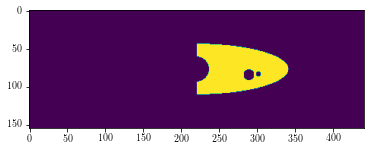

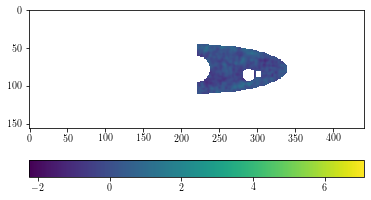

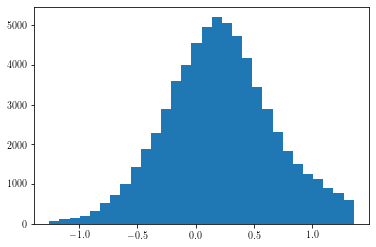

In [292]:
this_mask= mask_set[0]
P0_test = P0[0]
P1_test = P1[0]
plt.imshow(this_mask)
w0_bb = np.sum(this_mask*P0_test*data/noise**2)
#print('w0_bb ', w0_bb)
w1_bb = np.sum(this_mask*P1_test*fake_bmap/noise**2)
resids_bestfit = data-w0_bb*b0-w1_bb*b1
resids_bestfit_ma = ma.array(resids_bestfit, mask=np.logical_not(this_mask))
plt.figure()
plt.imshow(resids_bestfit_ma, vmin = minmin, vmax=maxmax)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.hist(resids_bestfit_ma.reshape(n*N), bins=30)
print('mean resid = ', np.mean(resids_bestfit_ma))
print('std resid = ', np.std(resids_bestfit_ma))
print(w0_bb)
print(w1_bb)

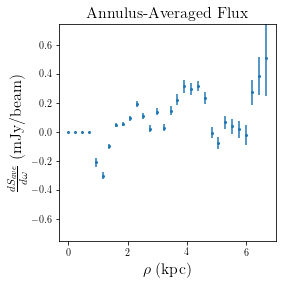

In [232]:
min_pix = pix_per_beam
num_bins = 30
this_mask = mask_set[0]
th_bins = np.linspace(0, np.max(THETA*this_mask), num_bins+1)
flux_bin = np.zeros(num_bins)
pix_bin = np.zeros(num_bins)
er_flux = np.zeros(num_bins)
for i in range(num_bins):
    bool_bin = np.logical_and(THETA>=th_bins[i], THETA<th_bins[i+1])
    pix_bin[i] = np.sum(bool_bin*this_mask)
    flux_bin[i] = np.sum(resids_bestfit*bool_bin*this_mask)

er_ring = np.array([np.sqrt(pix_bin[i]/pix_per_beam)*(np.sum(noise*bool_bin*this_mask)/pix_bin[i]) if not pix_bin[i]==0 else 0 \
           for i in range(num_bins)])
mean_bin = np.array([flux_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
er_beam = np.array([er_ring[i]*(pix_per_beam/pix_bin[i]) if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
fig = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.scatter(th_bins[0:-1]*DA, mean_bin, s=4)
plt.errorbar(th_bins[0:-1]*DA, mean_bin, yerr=er_beam, fmt='none')
ax = plt.gca()
ax.set_ylim([-0.75, 0.75])
plt.xlabel(r'$\rho \; \rm{(kpc)}$', size=16)
plt.ylabel(r'$\frac{dS_{ave}}{d\omega}\; \rm{(mJy/beam)}$', size=16)
plt.title(r'Annulus-Averaged Flux', size=16)
ax.set_box_aspect(1)

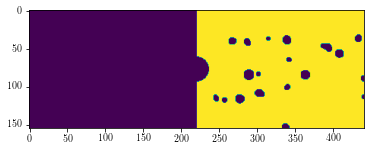

In [247]:
plt.imshow(base_mask)

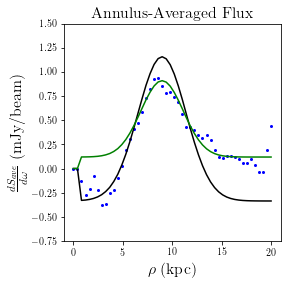

In [36]:
elliptic_d = np.sqrt((AX_n**2)*(w_fin2[2]**2) + AX_N**2)
min_pix = 1
num_bins = 50
this_mask = base_mask
th_bins = np.linspace(0, np.max(elliptic_d*this_mask), num_bins+1)
flux_bin = np.zeros(num_bins)
back_bin = np.zeros(num_bins)
back0_bin = np.zeros(num_bins)
pix_bin = np.zeros(num_bins)
er_flux = np.zeros(num_bins)
w_modified = [winside_fin[0], winside_fin[1], w_fin2[2], w_fin2[3], winside_fin[2]]
for i in range(num_bins):
    bool_bin = np.logical_and(elliptic_d>=th_bins[i], elliptic_d<th_bins[i+1])
    pix_bin[i] = np.sum(bool_bin*this_mask)
    flux_bin[i] = np.sum(data*bool_bin*this_mask)
    back_bin[i] = np.sum(f([AX_N, AX_n], w_modified)*bool_bin*this_mask)
    back0_bin[i] = np.sum(f([AX_N, AX_n], w_fin2)*bool_bin*this_mask)
er_ring = np.array([np.sqrt(pix_bin[i]/pix_per_beam)*(np.sum(noise*bool_bin*this_mask)/pix_bin[i]) if not pix_bin[i]==0 else 0 \
           for i in range(num_bins)])
mean_bin = np.array([flux_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
mean_back_bin = np.array([back_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
mean_back0_bin = np.array([back0_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
er_beam = np.array([er_ring[i]*(pix_per_beam/pix_bin[i]) if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
fig = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.scatter(th_bins[0:-1]*DA, mean_bin, s=4, color = 'b', label='data')
plt.plot(th_bins[0:-1]*DA, mean_back_bin, color = 'k', label='inner background')
plt.plot(th_bins[0:-1]*DA, mean_back0_bin, color= 'g', label='outer background')
#plt.errorbar(th_bins[0:-1]*DA, mean_bin, yerr=er_beam, fmt='none')
ax = plt.gca()
ax.set_ylim([-0.75, 1.5])
#ax.set_xlim([0, np.max(this_mask*elliptic_d*DA)])
plt.xlabel(r'$\rho \; \rm{(kpc)}$', size=16)
plt.ylabel(r'$\frac{dS_{ave}}{d\omega}\; \rm{(mJy/beam)}$', size=16)
plt.title(r'Annulus-Averaged Flux', size=16)
ax.set_box_aspect(1)
plt.savefig(fig_path + 'elliptical_annulus_averaged_flux_refloat_width.pdf')
r = th_bins[0:-1]*DA
c = 2
offset = -0.4
gaussian = c*np.exp(-(r-9.26)**2/(2*2.39**2)) + offset
#plt.plot(r, gaussian, color='r')

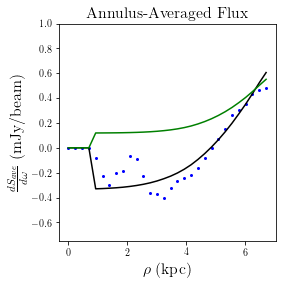

In [38]:
elliptic_d = np.sqrt((AX_n**2)*(w_fin2[2]**2) + AX_N**2)
min_pix = 1
num_bins = 30
this_mask = mask_set[0]
th_bins = np.linspace(0, np.max(elliptic_d*this_mask), num_bins+1)
flux_bin = np.zeros(num_bins)
back_bin = np.zeros(num_bins)
back0_bin = np.zeros(num_bins)
pix_bin = np.zeros(num_bins)
er_flux = np.zeros(num_bins)
for i in range(num_bins):
    bool_bin = np.logical_and(elliptic_d>=th_bins[i], elliptic_d<th_bins[i+1])
    pix_bin[i] = np.sum(bool_bin*this_mask)
    flux_bin[i] = np.sum(data*bool_bin*this_mask)
    back_bin[i] = np.sum(f([AX_N, AX_n], w_modified)*bool_bin*this_mask)
    back0_bin[i] = np.sum(f([AX_N, AX_n], w_fin2)*bool_bin*this_mask)
er_ring = np.array([np.sqrt(pix_bin[i]/pix_per_beam)*(np.sum(noise*bool_bin*this_mask)/pix_bin[i]) if not pix_bin[i]==0 else 0 \
           for i in range(num_bins)])
mean_bin = np.array([flux_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
mean_back_bin = np.array([back_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
mean_back0_bin = np.array([back0_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
er_beam = np.array([er_ring[i]*(pix_per_beam/pix_bin[i]) if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
fig = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.scatter(th_bins[0:-1]*DA, mean_bin, s=4, color = 'b', label='data')
plt.plot(th_bins[0:-1]*DA, mean_back_bin, color = 'k', label='inner background')
plt.plot(th_bins[0:-1]*DA, mean_back0_bin, color= 'g', label='outer background')
#plt.errorbar(th_bins[0:-1]*DA, mean_bin, yerr=er_beam, fmt='none')
ax = plt.gca()
ax.set_ylim([-0.75, 1])
#ax.set_xlim([0, np.max(this_mask*elliptic_d*DA)])
plt.xlabel(r'$\rho \; \rm{(kpc)}$', size=16)
plt.ylabel(r'$\frac{dS_{ave}}{d\omega}\; \rm{(mJy/beam)}$', size=16)
plt.title(r'Annulus-Averaged Flux', size=16)
ax.set_box_aspect(1)
plt.savefig(fig_path + 'elliptical_annulus_averaged_flux_refloat_zoomed.pdf')
r = th_bins[0:-1]*DA
c = 2
offset = -0.4
gaussian = c*np.exp(-(r-9.26)**2/(2*2.39**2)) + offset
#plt.plot(r, gaussian, color='r')

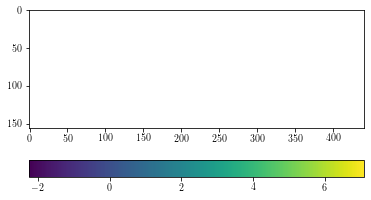

In [300]:
extra_inds = np.where(elliptic_d<1/780)
mask_inds_extra = np.array([np.concatenate((mask_inds[i], extra_inds[i])) for i in range(2)])
mask_inds = tuple(np.unique(mask_inds_extra, axis=1))
this_mask = create_mask(THETA, [0, np.pi], ps_ind=mask_inds, coords=(AX_N, AX_n), ellipse_params=[ell_params[1], ell_params[2], ell_params[3]], \
                        method='ellipse_azimuthallysym_outside', rl=rl_mask)
masked_resid = ma.array(resids_bestfit, mask=np.logical_not(this_mask))
plt.imshow(masked_resid, vmin=minmin, vmax=maxmax)
plt.colorbar(orientation='horizontal')
                

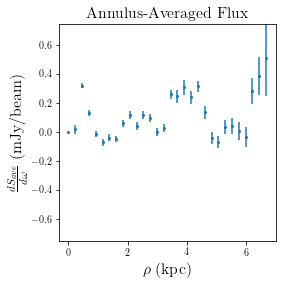

In [234]:
elliptic_d = np.sqrt(AX_n**2/w_fin2[2]**2 + AX_N**2)
num_bins = 30
this_mask = create_mask(THETA, [0, np.pi], ps_ind=mask_inds, coords=(AX_N, AX_n), ellipse_params=[ell_params[1], ell_params[2], ell_params[3]], \
                        method='ellipse_azimuthallysym_outside', rl=rl_mask)
th_bins = np.linspace(0, np.max(elliptic_d*this_mask), num_bins+1)
flux_bin = np.zeros(num_bins)
pix_bin = np.zeros(num_bins)
er_flux = np.zeros(num_bins)
for i in range(num_bins):
    bool_bin = np.logical_and(elliptic_d>=th_bins[i], elliptic_d<th_bins[i+1])
    pix_bin[i] = np.sum(bool_bin*this_mask)
    flux_bin[i] = np.sum(resids_bestfit*bool_bin*this_mask)

er_ring = np.array([np.sqrt(pix_bin[i]/pix_per_beam)*(np.sum(noise*bool_bin*this_mask)/pix_bin[i]) if not pix_bin[i]==0 else 0 \
           for i in range(num_bins)])
mean_bin = np.array([flux_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
er_beam = np.array([er_ring[i]*(pix_per_beam/pix_bin[i]) if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
fig = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.scatter(th_bins[0:-1]*DA, mean_bin, s=4)
plt.errorbar(th_bins[0:-1]*DA, mean_bin, yerr=er_beam, fmt='none')
ax = plt.gca()
ax.set_ylim([-0.75, 0.75])
plt.xlabel(r'$\rho \; \rm{(kpc)}$', size=16)
plt.ylabel(r'$\frac{dS_{ave}}{d\omega}\; \rm{(mJy/beam)}$', size=16)
plt.title(r'Annulus-Averaged Flux', size=16)
ax.set_box_aspect(1)

In [302]:
dchi2_data = dchi2_b[:,:,:,-1]
dchi2_b = dchi2_b[:, :, :, 0:int(num_samples/2)]
dchi2_sb = dchi2_sb[:, :, :, int(num_samples/2):num_samples]
dchi2_b_mean = np.mean(dchi2_b[:,:,:,:], axis=-1)
dchi2_b_std = np.std(dchi2_b[:,:,:,:], axis=-1)
dchi2_sb_mean = np.mean(dchi2_sb[:,:,:,:], axis=-1)
dchi2_sb_std = np.std(dchi2_sb[:,:,:,:], axis=-1)

In [303]:
print(dchi2_b_std[0, mchi, sv])
print(dchi2_b_mean[0, mchi, sv])
print(dchi2_data[0, mchi, sv])

322.9444555355174
483.56294056980425
624.928064663291


In [1]:
m=0
mchi = 28
sv = 40
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure()
max_dchi = max(np.max(dchi2_b[m, mchi, sv]), np.max(dchi2_sb[m, mchi, sv]))
min_dchi = min(np.min(dchi2_b[m, mchi, sv]), np.min(dchi2_sb[m, mchi, sv]))
bins_dchi2 = np.linspace(min_dchi, max_dchi, 50)
delta_bin = bins_dchi2[1]-bins_dchi2[0]

mu_sb = dchi2_sb_mean[m, mchi, sv]
sig_sb = dchi2_sb_std[m, mchi, sv]
mu_b = dchi2_b_mean[m, mchi, sv]
sig_b = dchi2_b_std[m, mchi, sv]
dchi_full = np.linspace(min_dchi, max_dchi, 1000)
pdf_sb = (1/(np.sqrt(2*np.pi)*sig_sb))*np.exp(-(dchi_full-mu_sb)**2/(2*sig_sb**2))
pdf_b = (1/(np.sqrt(2*np.pi)*sig_b))*np.exp(-(dchi_full-mu_b)**2/(2*sig_b**2))

plt.hist(dchi2_b[m, mchi, sv], bins=bins_dchi2, alpha=.4, color='b', density=True)
plt.hist(dchi2_sb[m, mchi, sv], bins=bins_dchi2, alpha=.4, color='r', density=True)
plt.axvline(x=dchi2_data[m, mchi, sv], color='g', label='data')
plt.plot(dchi_full, pdf_b, label='b', color='b')
plt.plot(dchi_full, pdf_sb, label='s+b', color='r')
plt.title(r'$\langle\sigma v\rangle=' + latex_float(sigmav_ar[sv], 3) + r'\;\rm{cm^3/s}$', size = 16)
plt.xlabel(r'$TS$', size=15)
plt.ylabel(r'Density', size=15)
xmin = min_dchi-delta_bin
xmax = max_dchi+delta_bin
plt.xlim([xmin, xmax])
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_box_aspect(1)
#plt.savefig(fig_path + 'sample_hist2.pdf')

#test gaussian approx
this_dchi2b_srt = np.sort(dchi2_b[m, mchi, sv])
this_dchi_mean = dchi2_b_mean[m, mchi, sv]
this_dchi_std = dchi2_b_std[m, mchi, sv]
p_ar_b = np.arange(1, len(this_dchi2b_srt)+1)/len(this_dchi2b_srt)
mini_b = np.min(this_dchi2b_srt)
maxi_b = this_dchi2b_srt[-2]
z_range = 5
num_z = 1000
z = np.linspace(-z_range, z_range, num_z)
dchi_ar = this_dchi_std*z+this_dchi_mean
p_unit = norm.cdf(z)
minz = -3
maxz = 3
min_p = norm.sf(-minz)
max_p = norm.sf(-maxz)
min_ind1 = int(np.round(min_p*num_samples))
max_ind1 = int(np.round(max_p*num_samples))
min_ind2 = int(np.round(num_z*(minz+z_range)/(2*z_range)))
max_ind2 = int(np.round(num_z*(maxz+z_range)/(2*z_range))) 
fig = plt.figure()
plt.plot(dchi_ar[min_ind2:max_ind2], p_unit[min_ind2:max_ind2], label='norm cdf')
plt.plot(this_dchi2b_srt[min_ind1:max_ind1], p_ar_b[min_ind1:max_ind1], label='actual')
plt.title(r'testing gaussian approximation', size=16)
plt.xlabel(r'$\Delta \chi^2_0$', size =16)
plt.ylabel(r'$p(\Delta\chi^2<\Delta\chi^2_0)$', size=16)
plt.legend(loc='upper left')
#plt.savefig(base_path+ 'stat_pipeline_results/check_gauss_approx.pdf')


this_dchi2sb_srt = np.sort(dchi2_sb[m, mchi, sv])
p_ar_sb = np.arange(1, len(this_dchi2sb_srt)+1)/len(this_dchi2sb_srt)
mini_sb = np.min(this_dchi2sb_srt)
maxi_sb = this_dchi2sb_srt[-2]
logCL_b = interpolate.interp1d(this_dchi2b_srt, np.log(1-p_ar_b), kind='linear')
logCL_sb = interpolate.interp1d(this_dchi2sb_srt, np.log(1-p_ar_sb), kind='linear')
min_CLs = max(mini_b, mini_sb)
max_CLs = min(maxi_b, maxi_sb)
dchi_array = np.linspace(min_CLs, max_CLs, 1000)
CL_s = np.exp(logCL_sb(dchi_array))/np.exp(logCL_b(dchi_array))
CL_sb_gauss = 1-norm.cdf(dchi_full, loc=mu_sb, scale=sig_sb)
CL_b_gauss = 1-norm.cdf(dchi_full, loc=mu_b, scale=sig_b)
CL_s_gauss = CL_sb_gauss/CL_b_gauss
ind_95 = np.where(np.min(np.abs(CL_s_gauss-.05)) == np.abs(CL_s_gauss-.05))[0][0]
fig = plt.figure()
#plt.plot(dchi_full, CL_b_gauss, label=r'$CL_b$', color='b')
#plt.plot(dchi_full, CL_sb_gauss, label=r'$CL_{s+b}$', color='r')
plt.plot(dchi_full, CL_s_gauss, label=r'$CL_s$ - smoothed', color='k')
#plt.plot(dchi_array, CL_s, label=r'$CL_s$', color='.5')
plt.plot(this_dchi2b_srt, 1-p_ar_b, label=r'$CL_b$', color='b')
plt.plot(this_dchi2sb_srt, 1-p_ar_sb, label=r'$CL_{s+b}$', color='r')
plt.plot(dchi_array, CL_s, label=r'$CL_s$', color='.7')
plt.xlim([xmin, xmax])
#plt.ylim([0, .3])
plt.title(r'$\langle\sigma v\rangle=' + latex_float(sigmav_ar[sv], 3) + r'\;\rm{cm^3/s}$', size = 16)
plt.xlabel(r'$TS$', size=15)
plt.ylabel(r'$CL$', size=15)
plt.axvline(x=dchi2_data[m, mchi, sv], color='g', label='data')
plt.axvline(x=dchi_full[ind_95], color='c', label=r'$TS_{95}$')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax = plt.gca()
ax.set_box_aspect(1)
#plt.savefig(fig_path + 'CL_curves2.pdf')

NameError: name 'plt' is not defined

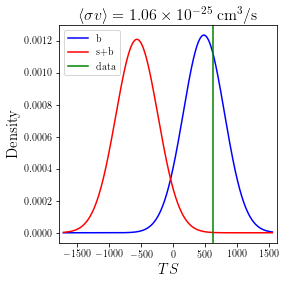

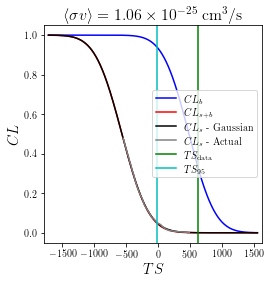

In [305]:
mu_sb = dchi2_sb_mean[m, mchi, sv]
sig_sb = dchi2_sb_std[m, mchi, sv]
mu_b = dchi2_b_mean[m, mchi, sv]
sig_b = dchi2_b_std[m, mchi, sv]
dchi_full = np.linspace(min_dchi, max_dchi, 1000)
pdf_sb = (1/(np.sqrt(2*np.pi)*sig_sb))*np.exp(-(dchi_full-mu_sb)**2/(2*sig_sb**2))
pdf_b = (1/(np.sqrt(2*np.pi)*sig_b))*np.exp(-(dchi_full-mu_b)**2/(2*sig_b**2))

plt.plot(dchi_full, pdf_b, label='b', color='b')
plt.plot(dchi_full, pdf_sb, label='s+b', color='r')
plt.axvline(x=dchi2_data[m, mchi, sv], color='g', label='data')
plt.title(r'$\langle\sigma v\rangle=' + latex_float(sigmav_ar[sv], 3) + r'\;\rm{cm^3/s}$', size = 16)
plt.xlabel(r'$TS$', size=15)
plt.ylabel(r'Density', size=15)
xmin = min_dchi-delta_bin
xmax = max_dchi+delta_bin
plt.xlim([xmin, xmax])
plt.legend()
ax = plt.gca()
ax.set_box_aspect(1)
#plt.savefig(fig_path + 'pdf_gauss2.pdf')

CL_sb_gauss = 1-norm.cdf(dchi_full, loc=mu_sb, scale=sig_sb)
CL_b_gauss = 1-norm.cdf(dchi_full, loc=mu_b, scale=sig_b)
CL_s_gauss = CL_sb_gauss/CL_b_gauss
ind_95 = np.where(np.min(np.abs(CL_s_gauss-.05)) == np.abs(CL_s_gauss-.05))[0][0]
fig = plt.figure()
plt.plot(dchi_full, CL_b_gauss, label=r'$CL_b$', color='b')
plt.plot(dchi_full, CL_sb_gauss, label=r'$CL_{s+b}$', color='r')
plt.plot(dchi_full, CL_s_gauss, label=r'$CL_s$ - Gaussian', color='k')
plt.plot(dchi_array, CL_s, label=r'$CL_s$ - Actual', color='.5')
plt.xlim([xmin, xmax])
plt.title(r'$\langle\sigma v\rangle=' + latex_float(sigmav_ar[sv], 3) + r'\;\rm{cm^3/s}$', size = 16)
plt.xlabel(r'$TS$', size=15)
plt.ylabel(r'$CL$', size=15)
plt.axvline(x=dchi2_data[m, mchi, sv], color='g', label=r'$TS_{\rm data}$')
plt.axvline(x=dchi_full[ind_95], color='c', label=r'$TS_{95}$')
plt.legend()
ax = plt.gca()
ax.set_box_aspect(1)
#plt.savefig(fig_path + 'CL_curves_gauss2.pdf')